<small>This notebook was put together by [wesley beckner](http://wesleybeckner.github.io)</small>


<a id='top'></a>

# Contents

[scrape data](#scrape)

[create descriptors](#descriptors)

[optimize LASSO](#optimize)

[create confidence intervals for coefficients](#ci_coeff)

[multi-layer perceptron (MLP) regressor](#nn)

[create static files](#static)

In [4]:
import statistics
import requests
import json
import pickle
import salty
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LINA
from scipy import stats
from scipy.stats import uniform as sp_rand
from scipy.stats import mode
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
import os
import sys
import pandas as pd
from collections import OrderedDict
from numpy.random import randint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from math import log
from time import sleep
%matplotlib inline

class dev_model():
    def __init__(self, coef_data, data):
        self.Coef_data = coef_data
        self.Data = data
        
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]   

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)  

<a id='scrape'></a>

# Scrape ILThermo Data

[back to top](#top)

ILThermo has specific 4-letter tags for the properties in the database. These can be determined by inspecting the web elements on their website.

Melting point: prp=lcRG (note this in the paper_url string)

All that needs to be changed to scrape other property data is the 4-letter tag and the directory in which to save the information.

In [12]:
paper_url = "http://ilthermo.boulder.nist.gov/ILT2/ilsearch?"\
    "cmp=&ncmp=1&year=&auth=&keyw=&prp=lcRG"
    
r = requests.get(paper_url)
header = r.json()['header']
papers = r.json()['res']
i = 1
data_url = 'http://ilthermo.boulder.nist.gov/ILT2/ilset?set={paper_id}'
for paper in papers[:1]:
    
    r = requests.get(data_url.format(paper_id=paper[0]))
    data = r.json()['data']
    with open("../salty/data/MELTING_POINT/%s.json" % i, "w") as outfile:
        json.dump(r.json(), outfile)
    #then do whatever you want to data like writing to a file
    sleep(0.5) #import step to avoid getting banned by server
    i += 1

<a id='descriptors'></a>

# Create Descriptors

[back to top](#top)

The scraped data is in the form of a json file. The json files contain all the experimental information NIST has archived, including methods and experimental error!

Unfortunately the IUPAC names in the database are imperfect. We address this after the following cell.

In [5]:
###add JSON files to density.csv
outer_old = pd.DataFrame()
outer_new = pd.DataFrame()
number_of_files = 2266

for i in range(2266):
    with open("../salty/data/DENSITY/%s.json" % str(i+1)) as json_file:
        
        #grab data, data headers (names), the salt name
        json_full = json.load(json_file)
        json_data = pd.DataFrame(json_full['data'])
        json_datanames = np.array(json_full['dhead'])
        json_data.columns =  json_datanames
        json_saltname = pd.DataFrame(json_full['components'])

        inner_old = pd.DataFrame()
        inner_new = pd.DataFrame()

        #loop through the columns of the data, note that some of the 
        #json files are missing pressure data. 
        if len(json_data.columns.values) > 3:
            print(json_data.columns.values)
        for indexer in range(len(json_data.columns)):
            grab=json_data.columns[indexer]
            list = json_data[grab]
            #my_list grabs first element
            #change l[0] to l[1] for error
            my_list = [l[0] for l in list]
            dfmy_list = pd.DataFrame(my_list)
            dfmy_list.columns = [json_datanames[indexer][0]]
            inner_new = pd.concat([dfmy_list, inner_old], axis=1)
            inner_old = inner_new

        #add the name of the salt    
        inner_old['salt_name']=json_saltname.iloc[0][3]           

        #add to the growing dataframe
        outer_new = pd.concat([inner_old, outer_old], axis=0)
        outer_old = outer_new
print(outer_old)
# pd.DataFrame.to_csv(outer_old, path_or_buf='../salty/data/density.csv', index=False)

    Molar volume, m<SUP>3</SUP>/mol Pressure, kPa  \
0                               NaN       101.325   
0                               NaN       101.325   
0                               NaN       101.325   
0                               NaN       101.325   
0                               NaN       101.325   
0                               NaN       101.325   
0                               NaN       101.325   
0                               NaN       101.325   
0                               NaN           101   
0                               NaN       101.325   
0                               NaN       101.325   
0                               NaN       101.325   
0                               NaN       101.325   
0                               NaN       101.325   
0                               NaN       101.325   
0                               NaN       101.325   
0                               NaN       101.325   
0                               NaN       101.

We can view an example of the raw data:

       Pressure, kPa  Specific density, kg/m<SUP>3</SUP>  Temperature, K
count     654.000000                          654.000000      654.000000
mean    37341.492164                         1272.809786      333.530454
std     53623.961553                           26.611532       48.049042
min       100.000000                         1163.000000      278.100000
25%       101.325000                         1261.725000      303.020000
50%     10012.000000                         1276.500000      313.200000
75%     50000.000000                         1288.700000      348.008500
max    200000.000000                         1342.000000      472.400000


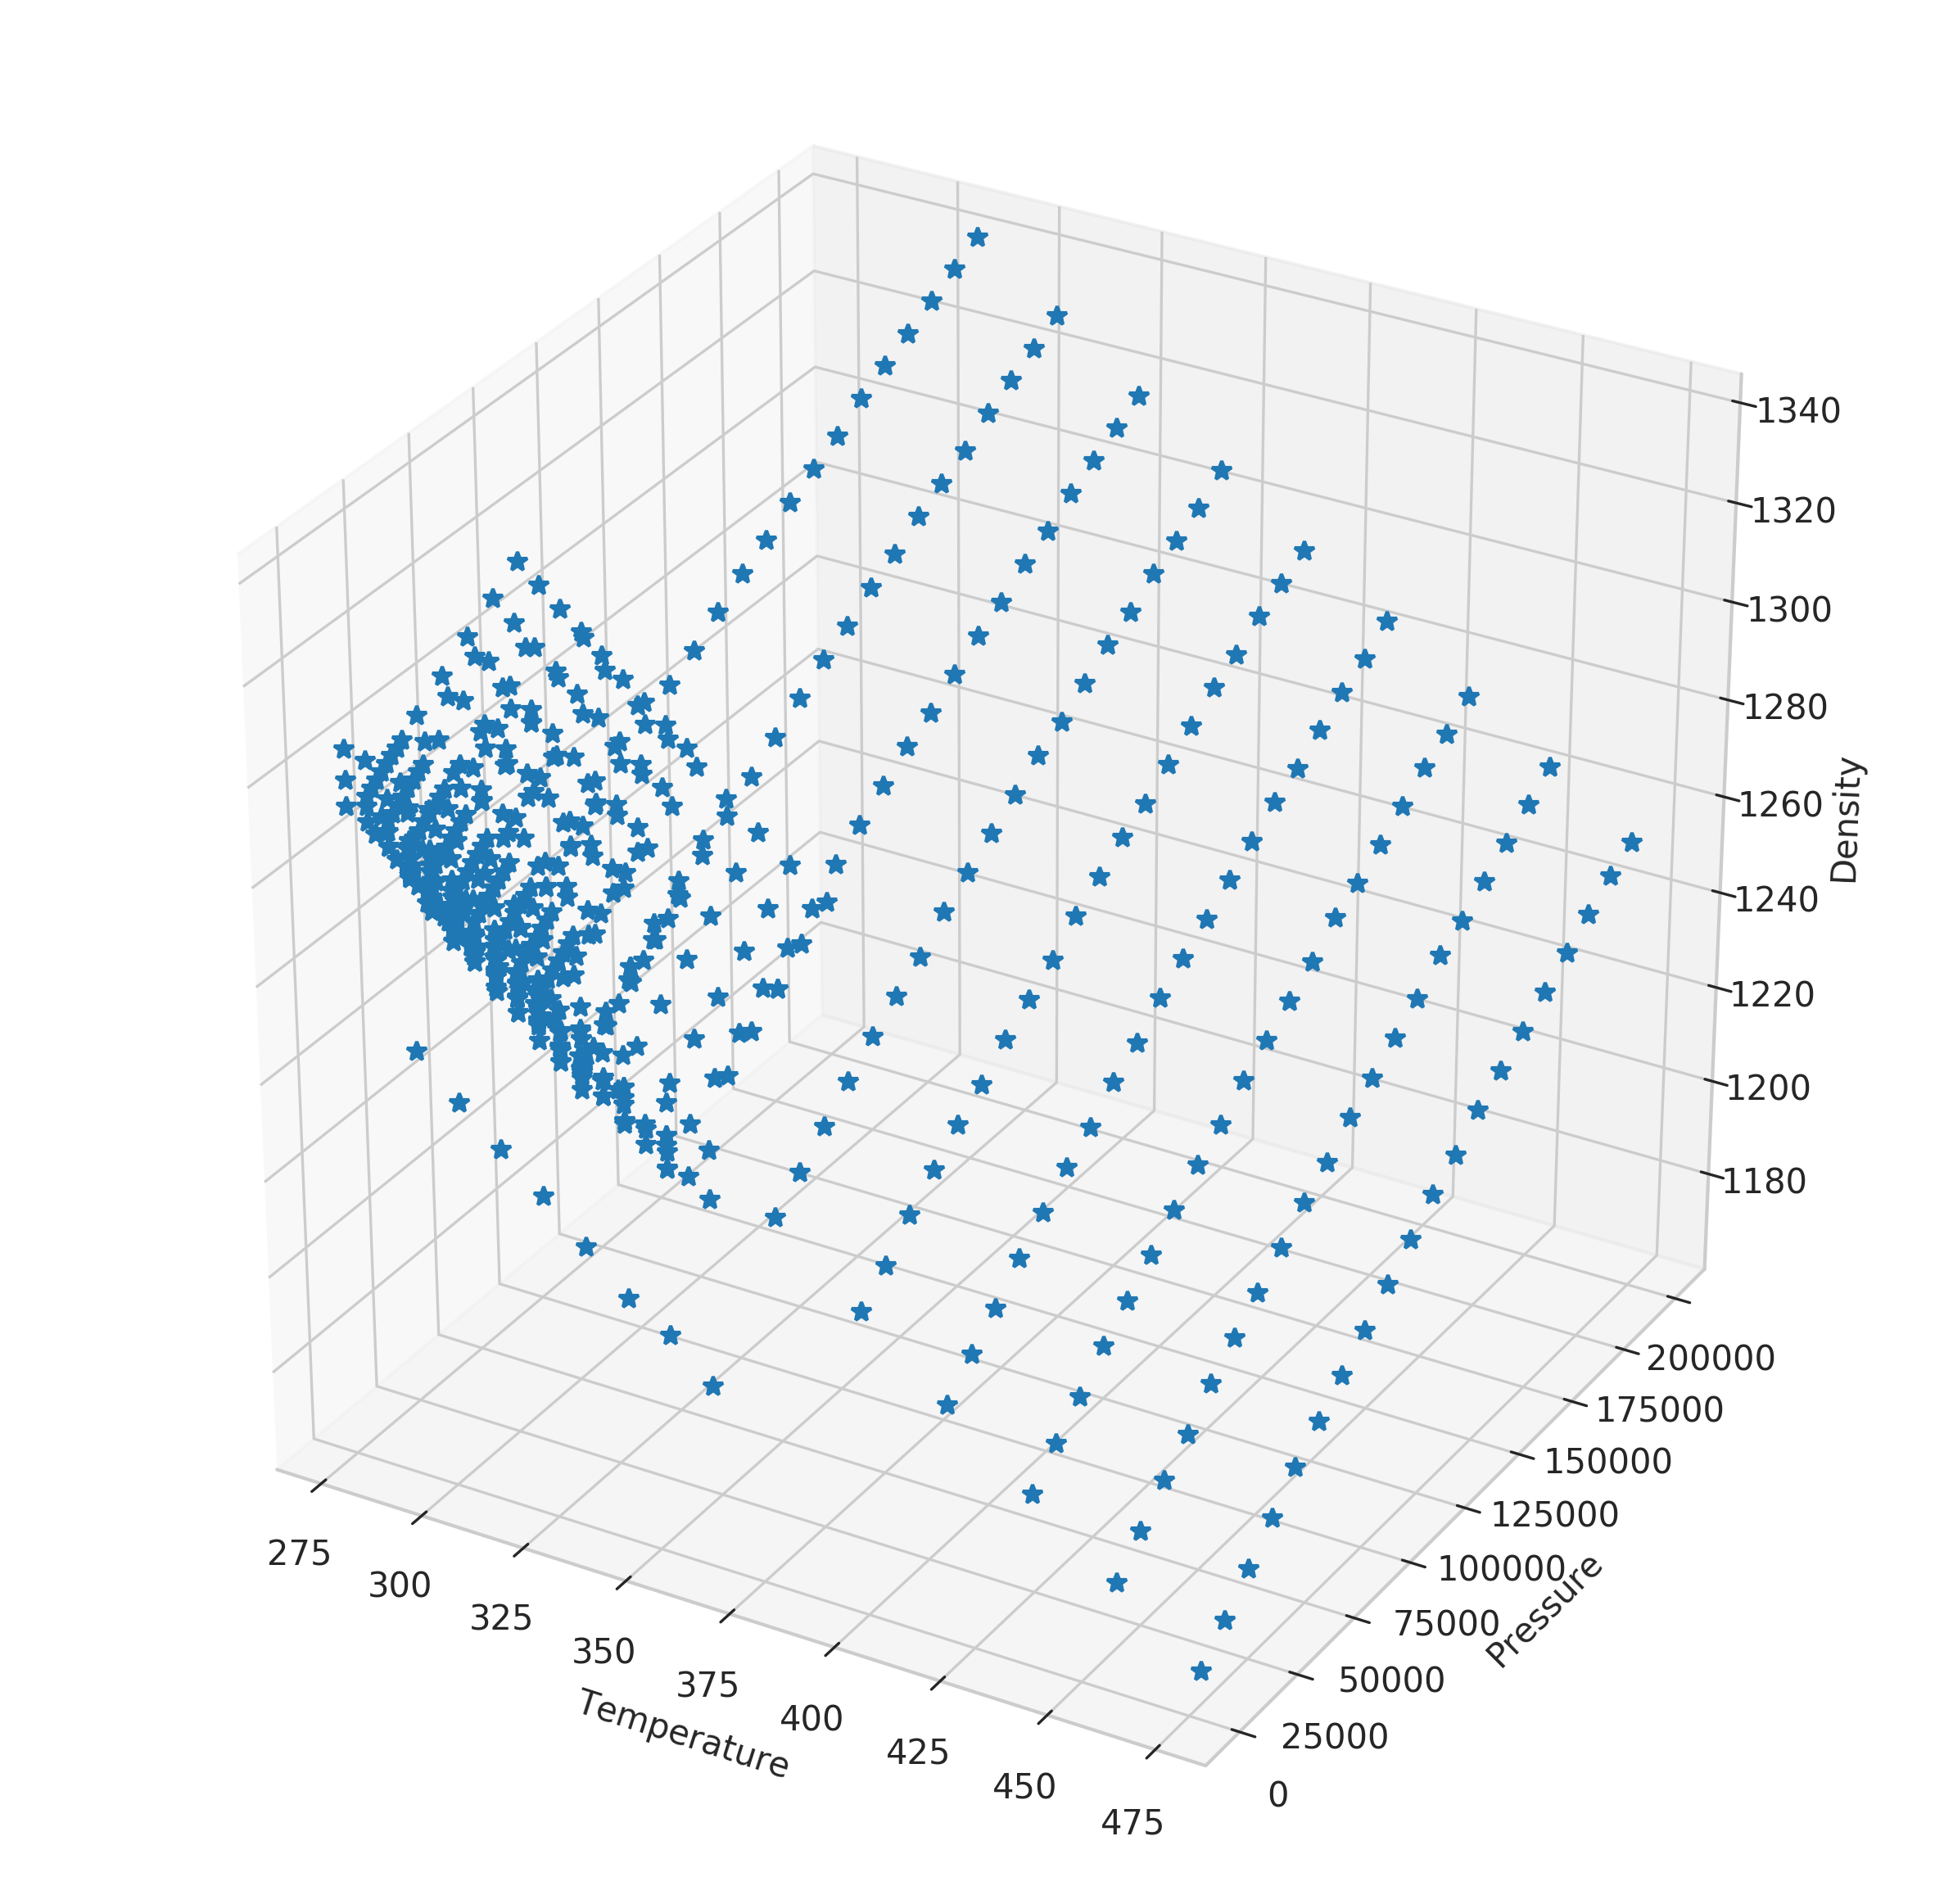

In [11]:
from mpl_toolkits.mplot3d import Axes3D
cols = outer_old.columns
df = outer_old.loc[outer_old["salt_name"] == "1-ethyl-3-methylimidazolium tetrafluoroborate"]
df = df[cols[[1,2,4]]]
df = df.astype(float)
print(df.describe())

df.reset_index(inplace=True, drop=True)
#df.boxplot()
df.dtypes

with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(10,10), dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(df["Temperature, K"],df["Pressure, kPa"] ,
            df["Specific density, kg/m<SUP>3</SUP>"],linestyle="None", marker="*")
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Pressure')
    ax.set_zlabel('Density')

Dealing with messy data is commonplace. *Even highly vetted data in ILThermo.*

I addressed inaccuracies in the IUPAC naming by first parsing the IUPAC names into two strings (caiton and anion) and then hand checking the strings that had more than two components. I then matched these **weird** IUPAC names to their correct SMILES representations. These are stored in the salty database file cationInfo.csv and anionInfo.csv.

In [132]:
df = pd.read_csv('../salty/data/density.csv',delimiter=',')
salts = pd.DataFrame(df["salt_name"])
salts = salts.rename(columns={"salt_name": "salts"})
anions= []
cations= []
missed = 0
for i in range(df.shape[0]):
    if len(salts['salts'].iloc[i].split()) == 2:
        cations.append(salts['salts'].iloc[i].split()[0])
        anions.append(salts['salts'].iloc[i].split()[1])
    elif len(salts['salts'].iloc[i].split()) == 3:
        if("sulfate" in salts['salts'].iloc[i] or\
        "phosphate" in salts['salts'].iloc[i] or\
        "phosphonate" in salts['salts'].iloc[i] or\
        "carbonate" in salts['salts'].iloc[i]):
            #these strings have two-word anions
            first = salts['salts'].iloc[i].split()[1]
            second = salts['salts'].iloc[i].split()[2]
            cations.append(salts['salts'].iloc[i].split()[0])
            anions.append(first + ' ' + second)
        elif("1:1" in salts["salts"].iloc[i]):
            #some strings contain the mixing ratio
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            cations.append(first)
            anions.append(second)
        elif("(OC-6-11)-hexafluoroantimonate(1-)" in salts["salts"].iloc[i]):
            #special case
            cations.append("1-butyl-3-methylimidazolium")
            anions.append("hexafluoroantimonate")
        elif("1,3-propanediol, 2-amino-2-(hydroxymethyl)-," in salts["salts"].iloc[i]):
            #special case
            cations.append("2-amino-2-(hydroxymethyl)-1,3-propanediol")
            anions.append("hydrochloride")
        else:
            #assume the rest are two-word cations
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            third = salts['salts'].iloc[i].split()[2]
            cations.append(first + ' ' + second)
            anions.append(third)
    elif len(salts['salts'].iloc[i].split()) == 4:
        #this particular string block contains (1:1) at end of name
        if("1,1,2,3,3,3-hexafluoro-1-propanesulfonate" in salts['salts'].iloc[i]):
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            cations.append(first + ' ' + second)
            anions.append(salts['salts'].iloc[i].split()[2])
        else:
            #and two word anion
            first = salts['salts'].iloc[i].split()[1]
            second = salts['salts'].iloc[i].split()[2]
            anions.append(first + ' ' + second)
            cations.append(salts['salts'].iloc[i].split()[0])
    elif("2-aminoethanol-2-hydroxypropanoate" in salts['salts'].iloc[i]):
        #one of the ilthermo salts is missing a space between cation/anion
        anions.append("2-hydroxypropanoate")
        cations.append("2-aminoethanol")
    elif len(salts['salts'].iloc[i].split()) == 5:
        if("bis[(trifluoromethyl)sulfonyl]imide" in salts['salts'].iloc[i]):
            anions.append("bis(trifluoromethylsulfonyl)imide")
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            third = salts['salts'].iloc[i].split()[2]
            fourth = salts['salts'].iloc[i].split()[3]
            cations.append(first + ' ' + second + ' ' + third + ' ' + fourth)
        if("trifluoro(perfluoropropyl)borate" in salts['salts'].iloc[i]):
            anions.append("trifluoro(perfluoropropyl)borate")
            cations.append("N,N,N-triethyl-2-methoxyethan-1-aminium")
    elif("1H-imidazolium, 1-ethyl-3-methyl-, salt with trifluoroacetic acid (1:1)"
        in salts['salts'].iloc[i]):
        anions.append("trifluoroacetic acid")
        cations.append("1-ethyl-3-methyl-1H-imidazolium")
    elif("L-alanine, 1-methylethyl ester, dodecyl sulfate (1:1)"
        in salts['salts'].iloc[i]):
        anions.append("dodecyl sulfate")
        cations.append("L-alanine, 1-methylethyl ester")
    else:
        print(salts['salts'].iloc[i])
        missed += 1
anions = pd.DataFrame(anions, columns=["name-anion"])
cations = pd.DataFrame(cations, columns=["name-cation"])
# salts=pd.read_csv('../salty/data/salts_with_smiles.csv',delimiter=',')
# new_df = pd.concat([salts["name-cation"], salts["name-anion"], salts["Temperature, K"],\
#                     salts["Pressure, kPa"], salts["Specific density, kg/m<SUP>3</SUP>"]],\
#                    axis = 1)
print(missed)

0


After appending SMILES to the dataframe, we're ready to add RDKit descriptors. Because the descriptors are specific to a given cation and anion, and there are many repeats of these within the data (~10,000 datapoints with ~300 cations and ~150 anions) it is much faster to use pandas to append existing descriptor dataframes to our growing dataframe from ILThermo.

In [133]:
cationDescriptors = salty.load_data("cationDescriptors.csv")
cationDescriptors.columns = [str(col) + '-cation' for col in cationDescriptors.columns]
anionDescriptors = salty.load_data("anionDescriptors.csv")
anionDescriptors.columns = [str(col) + '-anion' for col in anionDescriptors.columns]

In [134]:
new_df = pd.concat([cations, anions, df["Temperature, K"], df["Pressure, kPa"],\
                    df["Specific density, kg/m<SUP>3</SUP>"]], axis=1)
new_df = pd.merge(cationDescriptors, new_df, on="name-cation", how="right")
new_df = pd.merge(anionDescriptors, new_df, on="name-anion", how="right")
new_df.dropna(inplace=True) #remove entries not in smiles database

In [135]:
pd.DataFrame.to_csv(new_df, path_or_buf='../salty/data/density_premodel.csv', index=False)

<a id='optimize'></a>

# Optimize LASSO (alpha hyperparameter)

[back to top](#top)

**I like to shrink my feature space before feeding it into a neural network. **

This is useful for two reasons. We can combat overfitting in our neural network and we can speed up our genetic search algorithm by reducing the number of computations needed in our fitness test--more on this later.

Scikit-learn has a random search algorithm that is pretty easy to implement and useful. I've personally used bootstrap, cross validation, and shuffle-split to parameterize LASSO on ILThermo data and they all agree pretty well with each other. 

In [137]:
property_model = "density"
df = pd.DataFrame.from_csv('../salty/data/%s_premodel.csv' % property_model, index_col=None)
metaDf = df.select_dtypes(include=["object"])
dataDf = df.select_dtypes(include=[np.number])
property_scale = dataDf["Specific density, kg/m<SUP>3</SUP>"].apply(lambda x: log(float(x)))
cols = dataDf.columns.tolist()
instance = StandardScaler()
data = pd.DataFrame(instance.fit_transform(dataDf.iloc[:,:-1]), columns=cols[:-1])
df = pd.concat([data, property_scale, metaDf], axis=1)
mean_std_of_coeffs = pd.DataFrame([instance.mean_,instance.scale_], columns=cols[:-1])
viscosity_devmodel = dev_model(mean_std_of_coeffs, df)
pickle_out = open("../salty/data/%s_devmodel.pkl" % property_model, "wb")
pickle.dump(viscosity_devmodel, pickle_out)
pickle_out.close()

**At this point I introduce a new class of objects called devmodel. **

devmodel is a pickle-able object. self.Data contains the scaled/centered feature data and log of the property data as well as the original IUPAC names and SMILES. This makes it easy to consistently unpickle the devmodel and begin using it in an sklearn algorithm without making changes to the dataframe. Self.Coef_data contains the mean and standard deviation of the features so that structure candidates in our genetic algorithm can be scaled and centered appropriately.

In [138]:
pickle_in = open("../salty/data/%s_devmodel.pkl" % property_model, "rb")
devmodel = pickle.load(pickle_in)
df = devmodel.Data
metaDf = df.select_dtypes(include=["object"])
dataDf = df.select_dtypes(include=[np.number])
X_train = dataDf.values[:,:-1]
Y_train = dataDf.values[:,-1]
#metaDf["Specific density, kg/m<SUP>3</SUP>"].str.split().apply(lambda x: log(float(x[0])))

And now we can parameterize our LASSO model:

In [139]:
#param_grid = {"alpha": sp_rand(0,0.1), "hidden_layer_sizes" : [randint(10)]}
# model = MLPRegressor(max_iter=10000,tol=1e-8)
param_grid = {"alpha": sp_rand(0.001,0.1)}
model = Lasso(max_iter=1e5,tol=1e-8)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1,\
                         n_iter=15)
grid_result = grid.fit(X_train, Y_train)
print(grid_result.best_estimator_)

Lasso(alpha=0.00418107495047254, copy_X=True, fit_intercept=True,
   max_iter=100000.0, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=1e-08, warm_start=False)


<a id='ci_coeff'></a>

# Determine Confidence Intervals for LASSO Coefficients

[back to top](#top)

It can be incredibly useful to look at our coefficient response to changes in the underlying training data (e.g. does it look like one of our features are being selected because of a single type of training datum, category of salt, etc.)

This can be assessed using the bootstrap.

In [140]:
iterations=300
averages=np.zeros(iterations)
variances=np.zeros(iterations)
test_MSE_array=[]

property_model = "density"
pickle_in = open("../salty/data/%s_devmodel.pkl" % property_model, "rb")
devmodel = pickle.load(pickle_in)
df = devmodel.Data
df = df.sample(frac=1)
# df["Viscosity, Pas"] = df["Viscosity, Pas"].str.split().apply(lambda x: log(float(x[0])))
metadf = df.select_dtypes(include=["object"])
datadf = df.select_dtypes(include=[np.number])

          
data=np.array(datadf)
n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*0.8) #set fraction of data to be for training
n_test  = n - n_train
deslist=datadf.columns
score=np.zeros(len(datadf.columns))
feature_coefficients=np.zeros((len(datadf.columns),iterations))
test_MSE_array=[]
model_intercept_array=[]
for i in range(iterations):
    data = np.random.permutation(data) 
    X_train = np.zeros((n_train,d)) #prepare train/test arrays
    X_test  = np.zeros((n_test,d))
    Y_train = np.zeros((n_train))
    Y_test = np.zeros((n_test))

    ###sample from training set with replacement
    for k in range(n_train):
        x = randint(0,n_train)
        X_train[k] = data[x,:-1]
        Y_train[k] = (float(data[x,-1]))
    n = data.shape[0]
    ###sample from test set with replacement
    for k in range(n_test):
        x = randint(n_train,n)
        X_test[k] = data[x,:-1]
        Y_test[k] = (float(data[x,-1]))

    ###train the lasso model    
    model = Lasso(alpha=0.007115873059701538,tol=1e-10,max_iter=4000)
    model.fit(X_train,Y_train)
    
    ###Check what features are selected
    p=0
    avg_size=[]
    for a in range(len(data[0])-1):
        if model.coef_[a] != 0:
            score[a] = score[a] + 1
            feature_coefficients[a,i] = model.coef_[a] ###append the model coefs 
            p+=1
    avg_size.append(p)
    
    ###Calculate the test set MSE
    Y_hat = model.predict(X_test)
    n = len(Y_test)
    test_MSE = np.sum((Y_test-Y_hat)**2)**1/n
    test_MSE_array.append(test_MSE)
    
    ###Grab intercepts
    model_intercept_array.append(model.intercept_)
    
print("{}\t{}".format("average feature length:", np.average(avg_size)))
print("{}\t{}".format("average y-intercept:", "%.2f" % np.average(model_intercept_array)))
print("{}\t{}".format("average test MSE:", "%.2E" % np.average(test_MSE_array)))
print("{}\t{}".format("average MSE std dev:", "%.2E" % np.std(test_MSE_array)))
select_score=[]
select_deslist=[]
feature_coefficient_averages=[]
feature_coefficient_variance=[]
feature_coefficients_all=[]
for a in range(len(deslist)):
    if score[a] != 0:
        select_score.append(score[a])
        select_deslist.append(deslist[a])
        feature_coefficient_averages.append(np.average(feature_coefficients[a,:]))
        feature_coefficient_variance.append(np.std(feature_coefficients[a,:]))
        feature_coefficients_all.append(feature_coefficients[a,:])

average feature length:	19.0
average y-intercept:	7.10
average test MSE:	2.01E-03
average MSE std dev:	9.30E-05


Executing the following cell will overwrite saved files that were done for many bootstrap itterations.

In [141]:
#save the selected feature coeffs and their scores
df = pd.DataFrame(select_score, select_deslist)
df.to_pickle("../salty/data/bootstrap_list_scores.pkl")

#save the selected feature coefficients
df = pd.DataFrame(data=np.array(feature_coefficients_all).T, columns=select_deslist)
df = df.T.sort_values(by=1, ascending=False)
df.to_pickle("../salty/data/bootstrap_coefficients.pkl")

#save all the bootstrap data to create a box & whiskers plot
df = pd.DataFrame(data=[feature_coefficient_averages,\
                   feature_coefficient_variance], columns=select_deslist)
df = df.T.sort_values(by=1, ascending=False)
df.to_pickle("../salty/data/bootstrap_coefficient_estimates.pkl")

#save the coefficients sorted by their abs() values
df = pd.DataFrame(select_score, select_deslist)
df = df.sort_values(by=0, ascending=False).iloc[:]
cols = df.T.columns.tolist()
df = pd.read_pickle('../salty/data/bootstrap_coefficient_estimates.pkl')
df = df.loc[cols]
med = df.T.median()
med.sort_values()
newdf = df.T[med.index]
newdf.to_pickle('../salty/data/bootstrap_coefficient_estimates_top_sorted.pkl')

df = pd.DataFrame(select_score, select_deslist)
df.sort_values(by=0, ascending=False)

,0
VSA_EState10-anion,300.0
SlogP_VSA5-anion,300.0
"Temperature, K",300.0
EState_VSA5-cation,300.0
PEOE_VSA6-cation,300.0
PEOE_VSA2-cation,300.0
RingCount-cation,300.0
Kappa3-anion,300.0
VSA_EState9-anion,300.0
"Pressure, kPa",300.0


(24, 300)


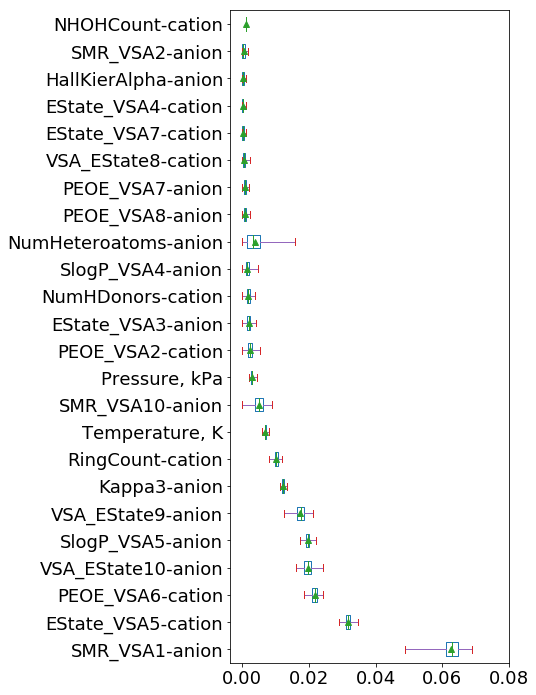

In [142]:
model = pd.read_pickle('../salty/data/bootstrap_coefficient_estimates_top_sorted.pkl')
model2 = model.abs()
df = model2.T.sort_values(by=0, ascending=False).iloc[:]
cols = df.T.columns.tolist()
df = pd.read_pickle('../salty/data/bootstrap_coefficients.pkl')
df = df.loc[cols]
med = df.T.median()
med.sort_values()
newdf = df.T[med.index]
newdf = newdf.replace(0, np.nan)
props = dict(boxes=tableau20[0], whiskers=tableau20[8], medians=tableau20[4],\
             caps=tableau20[6])
newdf.abs().plot(kind='box', figsize=(5,12), subplots=False, fontsize=18,\
        showmeans=True, logy=False, sharey=True, sharex=True, whis='range', showfliers=False,\
        color=props,  vert=False)
plt.xticks(np.arange(0,0.1,0.02))
print(df.shape)

It can also be useful to evaluate the t-scores for the coefficients.

In [143]:
df = pd.read_pickle('../salty/data/bootstrap_coefficients.pkl')
med = df.T.median()
med.sort_values()
newdf = df.T[med.index]
df = newdf
for index, string in enumerate(newdf.columns):
    print(string)
    
    #get mean, std, N, and SEM from our sample
    samplemean=np.mean(df[string])
    print('sample mean', samplemean)
    samplestd=np.std(df[string],ddof=1)
    print('sample std', samplestd)
    sampleN=1000
    samplesem=stats.sem(df[string])
    print('sample SEM', samplesem)

    #t, the significance level of our sample mean is defined as
    #samplemean - 0 / standard error of sample mean
    #in other words, the number of standard deviations
    #the coefficient value is from 0
    #the t value by itself does not tell us very much
    t=(samplemean)/samplesem
    print('t', t)

    #the p-value tells us the propbability of achieving a value
    #at least as extreme as the one for our dataset if the null
    #hypothesis were true
    p=stats.t.sf(np.abs(t),sampleN-1)*2 #multiply by two for two-sided test
    print('p', p)

    #test rejection of the null hypothesis based on 
    #significance level of 0.05
    alpha=0.05
    if p < alpha:
        print('reject null hypothesis')
    else:
        print('null hypothesis accepted')

SMR_VSA1-anion
sample mean 0.0624533732911495
sample std 0.002997892994534678
sample SEM 0.00017308343274
t 360.828141103
p 0.0
reject null hypothesis
Kappa3-anion
sample mean 0.012314718021847148
sample std 0.0003620053976667021
sample SEM 2.09003913791e-05
t 589.209924277
p 0.0
reject null hypothesis
RingCount-cation
sample mean 0.01030034515443378
sample std 0.0007337307629118836
sample SEM 4.2361965348e-05
t 243.150785612
p 0.0
reject null hypothesis
Pressure, kPa
sample mean 0.0029500783462444737
sample std 0.0003713941608156255
sample SEM 2.14424518722e-05
t 137.581204044
p 0.0
reject null hypothesis
SMR_VSA10-anion
sample mean 0.005032781832723195
sample std 0.0017256022689787012
sample SEM 9.96276934509e-05
t 50.5158923026
p 2.31874645716e-277
reject null hypothesis
VSA_EState8-cation
sample mean 0.0001981359198367968
sample std 0.00045064014912035304
sample SEM 2.60177211402e-05
t 7.61542176461
p 6.07879504358e-14
reject null hypothesis
EState_VSA7-cation
sample mean 0.0001377

# Create Models Progressively Dropping Features

[back to top](#top)

A last check that I find very useful is progressively dropping features from the LASSO model (based on their average coefficients--see box and whiskers plot above). At some point we should see that the inclusion of additional features doesn't improve the performance of the model. In this case we see improvement fall off at about 15-20 features.

In [144]:
mse_scores=[]
for i in range(df.shape[0]):
    model = pd.read_pickle('../salty/data/bootstrap_coefficient_estimates_top_sorted.pkl')
    model2 = model.abs()
    df = model2.T.sort_values(by=0, ascending=False).iloc[:i]
    cols = df.T.columns.tolist()
    model = model[cols]
    cols = model.columns.tolist()
    cols.append("Specific density, kg/m<SUP>3</SUP>")
    
    property_model = "density"
    pickle_in = open("../salty/data/%s_devmodel.pkl" % property_model, "rb")
    devmodel = pickle.load(pickle_in)
    df = devmodel.Data
    df = df.sample(frac=1)
    metadf = df.select_dtypes(include=["object"])
    datadf = df.select_dtypes(include=[np.number])
    df = datadf.T.loc[cols]
    data=np.array(df.T)

    n = data.shape[0]
    d = data.shape[1]
    d -= 1
    n_train = 0#int(n*0.8) #set fraction of data to be for training
    n_test  = n - n_train

    X_train = np.zeros((n_train,d)) #prepare train/test arrays
    X_test  = np.zeros((n_test,d))
    Y_train = np.zeros((n_train))
    Y_test = np.zeros((n_test))
    X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
    Y_train[:] = (data[:n_train,-1].astype(float))
    X_test[:] = data[n_train:,:-1]
    Y_test[:] = (data[n_train:,-1].astype(float))
    Y_hat = np.dot(X_test, model.loc[0])+np.mean(Y_test[:] - np.dot(X_test[:], model.loc[0]))
    n = len(Y_test)
    test_MSE = np.sum((Y_test-Y_hat)**2)**1/n
    mse_scores.append(test_MSE) 

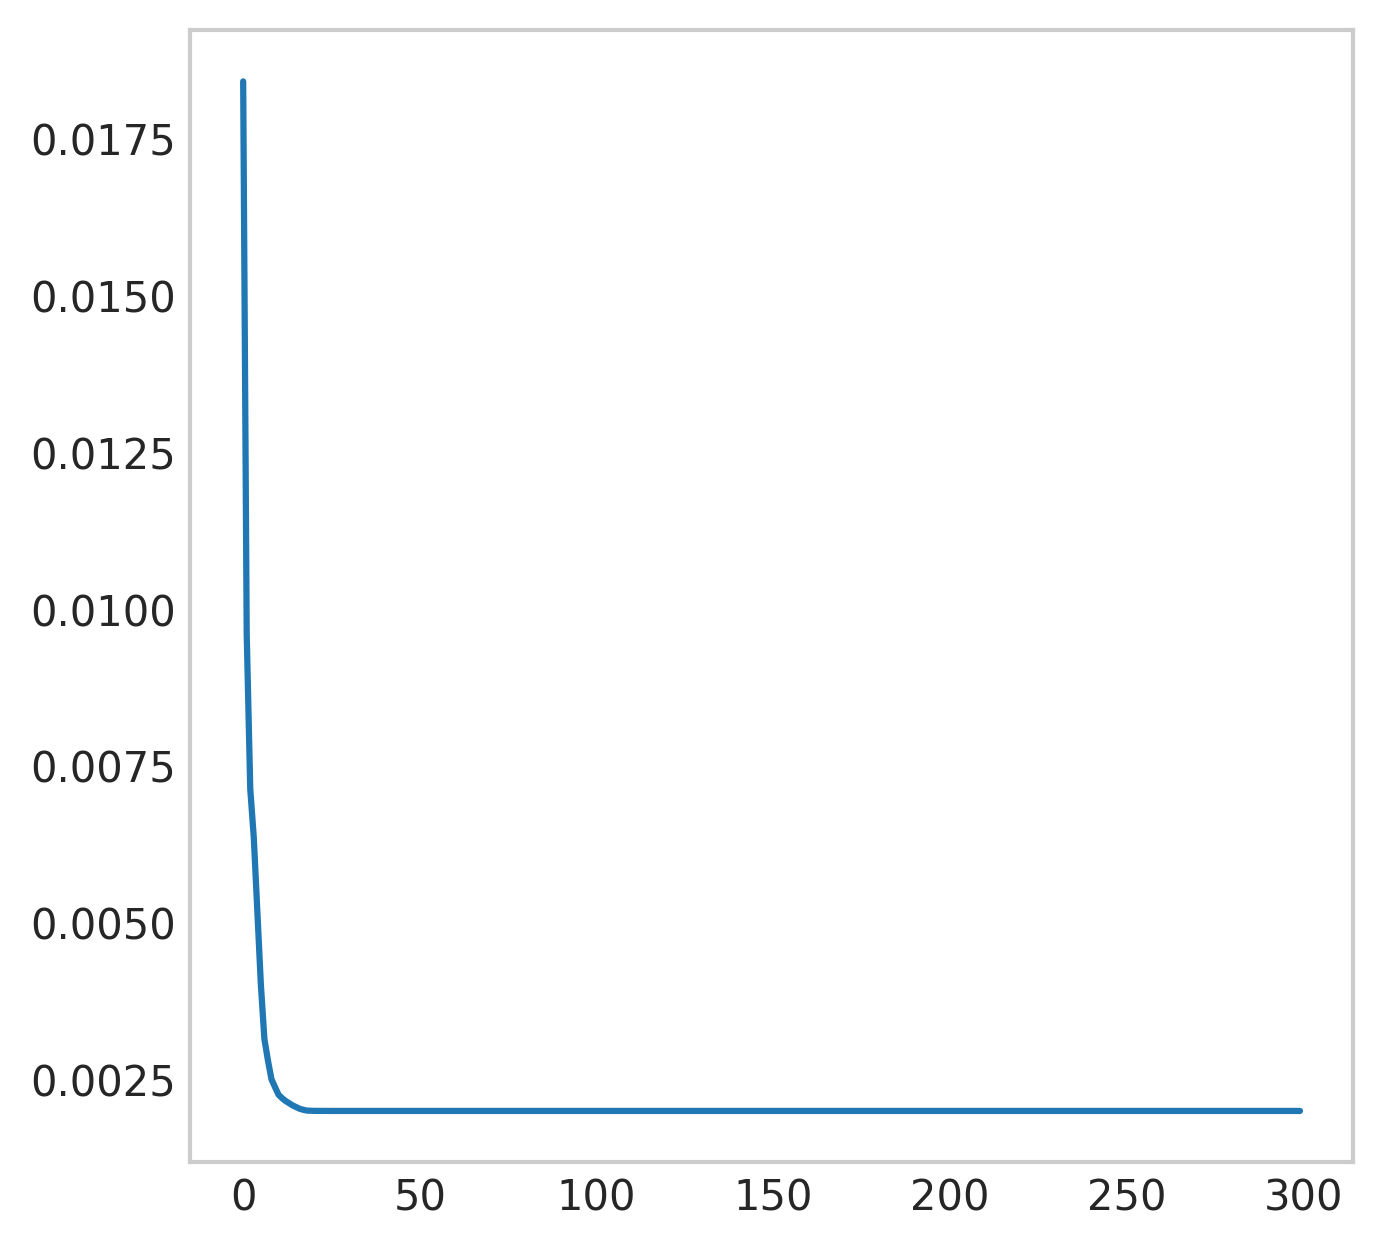

In [145]:
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(5,5), dpi=300)
    ax=fig.add_subplot(111)
    ax.plot(mse_scores)
    ax.grid(False)
# plt.xticks(np.arange(0,31,10))
# plt.yticks(np.arange(0,1.7,.4))

<a id='nn'></a>

# MLPRegressor

[back to top](#top)

I set avg_selected_features to the number of features I want to include based on the box-whiskers plot, t-tests, and progressively dropped features model. I've set this value to 20 in the cell bellow.

In [148]:
####Create dataset according to LASSO selected features
df = pd.read_pickle("../salty/data/bootstrap_list_scores.pkl")
df = df.sort_values(by=0, ascending=False)
avg_selected_features=32
df = df.iloc[:avg_selected_features]

# coeffs = mean_std_of_coeffs[cols]
property_model = "density"
pickle_in = open("../salty/data/%s_devmodel.pkl" % property_model, "rb")
devmodel = pickle.load(pickle_in)
rawdf = devmodel.Data
rawdf = rawdf.sample(frac=1)
metadf = rawdf.select_dtypes(include=["object"])
datadf = rawdf.select_dtypes(include=[np.number])
to_add=[]
for i in range(len(df)):
    to_add.append(df.index[i])
cols = [col for col in datadf.columns if col in to_add]
cols.append("Specific density, kg/m<SUP>3</SUP>")
df = datadf.T.loc[cols]

data=np.array(datadf)

n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*0.8) #set fraction of data to be for training
n_test  = n - n_train

X_train = np.zeros((n_train,d)) #prepare train/test arrays
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train))
Y_test = np.zeros((n_test))
X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
Y_train[:] = (data[:n_train,-1].astype(float))
X_test[:] = data[n_train:,:-1]
Y_test[:] = (data[n_train:,-1].astype(float))

I usually optimize my MLP regressor hyper parameters with any new type of dataset. This takes a long time to run so I use the Hyak supercomputer.

In [ ]:
###Randomized Search NN Characterization
param_grid = {"activation": ["identity", "logistic", "tanh", "relu"],\
             "solver": ["lbfgs", "sgd", "adam"], "alpha": sp_rand(),\
             "learning_rate" :["constant", "invscaling", "adaptive"],\
             "hidden_layer_sizes": [randint(100)]}

model = MLPRegressor(max_iter=400,tol=1e-8)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,\
                          n_jobs=-1, n_iter=10)
grid_result = grid.fit(X_train, Y_train)

print(grid_result.best_estimator_)

In [149]:
model = MLPRegressor(activation='logistic', alpha=0.92078, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=75, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1e8, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
       verbose=False, warm_start=False)
model.fit(X_train,Y_train)

MLPRegressor(activation='logistic', alpha=0.92078, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=75, learning_rate='constant',
       learning_rate_init=0.001, max_iter=100000000.0, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
       verbose=False, warm_start=False)

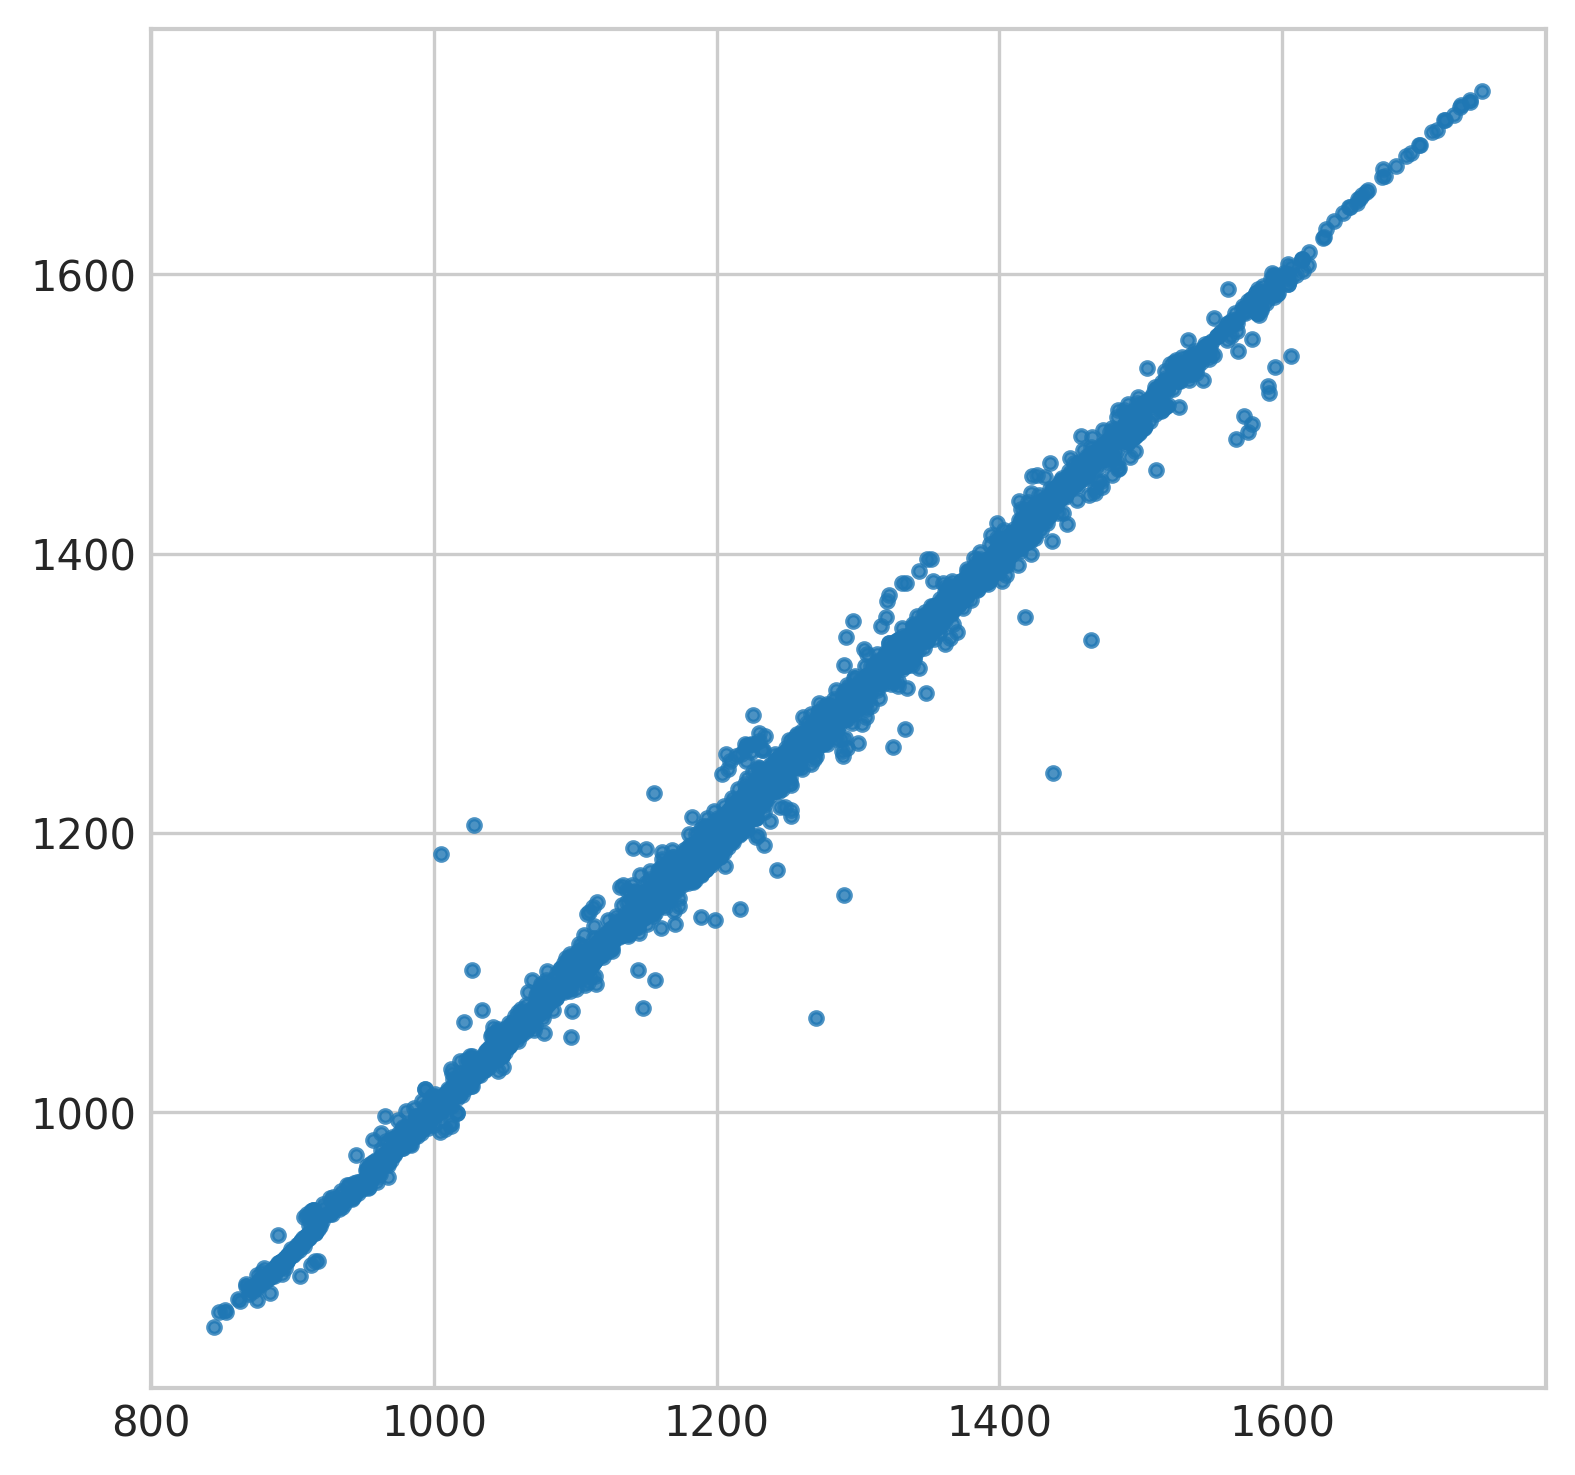

In [150]:
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(6,6), dpi=300)
    ax=fig.add_subplot(111)
    ax.plot(np.exp(Y_test),np.exp(model.predict(X_test)),\
            marker=".",linestyle="",alpha=0.8)

<a id='static'></a>

# Save the final model to be used in the [GAINS](https://github.com/wesleybeckner/gains) fitness test

[back to top](#top)

In [37]:
prodmodel = prod_model(coeffs, model)
pickle_out = open("../salty/data/%s_prodmodel.pkl" % property_model, "wb")
pickle.dump(prodmodel, pickle_out)
pickle_out.close()